<a href="https://colab.research.google.com/github/MattBaudoin/SCMT610_GroupProject/blob/dev/Group_Project_Part_A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Group 1

*   **Matthew Baudoin** - Setup environment, Stream raw dataset through cleanup job to Parquet, build Parquet chunk streaming utility
*  **Kevin Brown** - Explain reasoning behind pre-processing steps taken, difference between TF and TF-IDF Matrix
*   **Chelsea Jacobo** - Clean dataset
*   **Grace Morris** - Visualization insights into data
*   **Stephie Noel** - TF Matrix & TF-IDF Matrix
*   **Kal Zapotocky** - Visualize review length to star data relationship and make observations on review rating imbalance.







# NOTE: Our Kaggle dataset did not come with any source code, so everything was written from scratch.

# **Run Blocks 1-3 for Environment Setup**

In [1]:
#1 - Environment setup:

from google.colab import drive
drive.mount('/content/drive/')

ModuleNotFoundError: No module named 'google'

In [5]:
#2 - Environment setup: load dependencies & NLP Setup

from collections import Counter
from collections import defaultdict
import glob
import json
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import os
import pandas as pd
import re
import string
import time
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

def ensure_nltk_resource(resource):
    try:
        nltk.data.find(resource)
    except LookupError:
        nltk.download(resource.split("/")[-1])

ensure_nltk_resource("corpora/stopwords")
ensure_nltk_resource("corpora/wordnet")
ensure_nltk_resource("corpora/omw-1.4")

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()



ModuleNotFoundError: No module named 'matplotlib'

In [27]:
#3 - Configuration: Paths

BASE_DIR = (
    "/content/drive/Shared drives/Team1Share/GroupProject/"
    "Yelp_Dataset"
)

# Raw source dataset (immutable)
RAW_REVIEW_FILE = "yelp_academic_dataset_review.json"
RAW_REVIEW_PATH = os.path.join(BASE_DIR, RAW_REVIEW_FILE)

# Slimmed parquet dataset (derived)
SLIM_PARQUET_DIR = os.path.join(BASE_DIR, "reviews_slim_parquet")

# NLP-cleaned outputs (targets)
TEXT_CLEAN_CHUNK_DIR = os.path.join(BASE_DIR, "reviews_text_clean_parquet_chunks")


# ===== Configuration Validation =====

assert os.path.exists(RAW_REVIEW_PATH), f"Dataset not found: {RAW_REVIEW_PATH}"
assert os.path.exists(SLIM_PARQUET_DIR), f"Slim parquet dir missing: {SLIM_PARQUET_DIR}"

os.makedirs(TEXT_CLEAN_CHUNK_DIR, exist_ok=True)

print("Configuration validated")

Configuration validated


# **Blocks 4-6 dont need to be run again. This was only to inspect the original database**

In [ ]:
#4 - Exploratory Data Analysis: Samplethe raw JSONL and inspect
# NOTE: Do NOT load the full ~5GB JSONL into memory in Colab.

# The following code is retained for reference, but is not exectuted.

# df_raw = pd.read_json(DATA_PATH, lines=True)

# Instead, Load a small sample of the JSON Lines file for exploratory analysis

SAMPLE_N = 10_000  # number of lines to sample

rows = []
with open(RAW_REVIEW_PATH, "r") as f:
    for i, line in enumerate(f):
        if i >= SAMPLE_N:
            break
        rows.append(json.loads(line))

df_sample = pd.DataFrame(rows)

# Preview and inspect dataset
df_sample.head()

In [ ]:
#5 - Dataset dimensions and schema

print("Shape:", df_sample.shape)
print("Columns:", df_sample.columns)
df_sample.info()



Shape: (10001, 9)
Columns: Index(['review_id', 'user_id', 'business_id', 'stars', 'useful', 'funny',
       'cool', 'text', 'date'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001 entries, 0 to 10000
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   review_id    10001 non-null  object 
 1   user_id      10001 non-null  object 
 2   business_id  10001 non-null  object 
 3   stars        10001 non-null  float64
 4   useful       10001 non-null  int64  
 5   funny        10001 non-null  int64  
 6   cool         10001 non-null  int64  
 7   text         10001 non-null  object 
 8   date         10001 non-null  object 
dtypes: float64(1), int64(3), object(5)
memory usage: 703.3+ KB


In [8]:
#6 - One time Dataset construction retaining columns required for analysis: JSONL to Parquet
# Useful columns are: review_id, business_id, stars, text, date
#
# NOTE: Tried using CSV for the slimmed dataset, however it is still too large to load into Colabs memory.
# After research, parquet is the better file format, especially for large datasets for ML/Analytics pipelines


existing_parts = glob.glob(os.path.join(SLIM_PARQUET_DIR, "part_*.parquet"))
if existing_parts:
    print(f"Slim parquet already exists ({len(existing_parts)} files). Skipping rebuild.")
else:
    os.makedirs(SLIM_PARQUET_DIR, exist_ok=True)

# Record start time to measure end-to-end write performance
    start_time = time.time()
    n_parts = 0

# Stream the large JSON Lines file in blocks to avoid memory issues
# Each iteration writes one self-contained Parquet partition;
# the full dataset is represented by the collection of part files
    for df_block in pd.read_json(
        RAW_REVIEW_PATH,
        lines=True,
        chunksize=100_000
    ):
        df_block = df_block[
            ["review_id", "business_id", "stars", "text", "date"]
        ]

    # Construct a unique filename for this block to create a partitioned dataset
        part_path = os.path.join(
            SLIM_PARQUET_DIR,
            f"part_{n_parts:05d}.parquet"
        )

    # Write the current block to disk as a compressed Parquet file
        df_block.to_parquet(
            part_path,
            compression="snappy",
            index=False
        )

    # Increment part counter for the next block
        n_parts += 1

    elapsed = time.time() - start_time
    print(f"Reduced dataset written to: {SLIM_PARQUET_DIR}")
    print(f"Parquet files written: {n_parts}")
    print(f"Time elapsed: {elapsed / 60:.1f} minutes")



✅ Reduced dataset written to: /content/drive/Shared drives/Team1Share/GroupProject/Yelp_Dataset/reviews_slim_parquet
Parquet files written: 70
Time elapsed: 2.8 minutes


# You only NEED to run step 7 assuming you intend to clean and reduce noise from the semi-raw slimmed dataset. Steps 8-9 are for reinspecting the dataset

# If this isnt you, skip to step 13

In [10]:
#7 - Load reduced dataset from Parquet directory
# This creates a working copy for cleaning and pre-preocessing

# This cell is expensive, run it by itself

df_reduced = pd.read_parquet(SLIM_PARQUET_DIR)



In [ ]:
#8 - Preview Data

df_reduced.head()


,review_id,business_id,stars,text,date
0,KU_O5udG6zpxOg-VcAEodg,XQfwVwDr-v0ZS3_CbbE5Xw,3,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,7ATYjTIgM3jUlt4UM3IypQ,5,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,saUsX_uimxRlCVr67Z4Jig,YjUWPpI6HXG530lwP-fb2A,3,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
3,AqPFMleE6RsU23_auESxiA,kxX2SOes4o-D3ZQBkiMRfA,5,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
4,Sx8TMOWLNuJBWer-0pcmoA,e4Vwtrqf-wpJfwesgvdgxQ,4,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15


In [ ]:
#9 - Examine dataset structure

df_reduced.shape
df_reduced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6990280 entries, 0 to 6990279
Data columns (total 5 columns):
 #   Column       Dtype         
---  ------       -----         
 0   review_id    object        
 1   business_id  object        
 2   stars        int64         
 3   text         object        
 4   date         datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 266.7+ MB


 **Conduct cleaning and noise reduction on the working dataset you loaded into memory**

In [11]:
#10 - Basic quality cleanup and text cleaning functions

# Ensure text column is string
df_reduced["text"] = df_reduced["text"].astype("string")

# Remove missing reviews
df_reduced = df_reduced.dropna(subset=["text"])

# Remove empty / whitespace-only text
df_reduced = df_reduced[df_reduced["text"].str.strip() != ""]

# Remove duplicates and normalize index for chunking
df_reduced = df_reduced.drop_duplicates(subset=["text"]).reset_index(drop=True)

print("After basic cleanup complete:", df_reduced.shape)

# Text cleaning functions
def reduce_character_noise(word: str) -> str:
    """Reduce elongated words (e.g., soooo -> soo)."""
    return re.sub(r"(.)\1{2,}", r"\1\1", word)


def clean_review_text_method(text: str) -> str:
    """Method-based text preprocessing pipeline for Yelp reviews."""
    text = str(text).lower()

    # Remove URLs and emails
    text = re.sub(r"http\S+|www\.\S+|\S+@\S+", " ", text)

    # Remove punctuation and numbers
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = re.sub(r"\d+", " ", text)

    # Normalize whitespace
    text = re.sub(r"\s+", " ", text).strip()

    # Tokenize
    tokens = text.split()

    cleaned_tokens = []
    for token in tokens:
        token = reduce_character_noise(token)

        # Keep alphabetic words only and remove stopwords
        if token.isalpha() and token not in stop_words:
            token = lemmatizer.lemmatize(token)
            cleaned_tokens.append(token)

    return " ".join(cleaned_tokens)

After basic cleanup complete: (6974127, 5)


In [12]:
#11 - Apply cleaning method in managable chunks

CHUNK_SIZE = 25_000
LOG_EVERY  = 10

n = len(df_reduced)
total_chunks = (n + CHUNK_SIZE - 1) // CHUNK_SIZE

# Resume info
existing_files = glob.glob(os.path.join(TEXT_CLEAN_CHUNK_DIR, "chunk_*.parquet"))
existing_ids = {int(os.path.basename(f).split("_")[1].split(".")[0]) for f in existing_files} if existing_files else set()

print(f"Total rows to process: {n:,}")
print(f"Total chunks expected: {total_chunks:,}")
print(f"Chunks already on disk: {len(existing_ids):,}")

t0 = time.time()
processed_chunks = 0

for chunk_id in range(total_chunks):
    start = chunk_id * CHUNK_SIZE
    end = min(start + CHUNK_SIZE, n)
    chunk_path = os.path.join(TEXT_CLEAN_CHUNK_DIR, f"chunk_{chunk_id:05d}.parquet")

    # Resume: skip completed chunks
    if chunk_id in existing_ids or os.path.exists(chunk_path):
        continue

    chunk = df_reduced.iloc[start:end].copy()

    # Apply cleaning
    chunk["text_clean"] = chunk["text"].apply(clean_review_text_method)

    # Remove very short reviews (post-cleaning)
    chunk["clean_word_count"] = chunk["text_clean"].apply(lambda x: len(x.split()))
    chunk = chunk[chunk["clean_word_count"] >= 3]

    # DROP raw text and any temp columns
    chunk = chunk[["review_id", "business_id", "stars", "date", "text_clean"]]

    # Write checkpoint
    chunk.to_parquet(chunk_path, index=False)

    processed_chunks += 1

    # Lightweight logging
    if processed_chunks % LOG_EVERY == 0:
        elapsed = time.time() - t0
        done_chunks = chunk_id + 1
        pct = 100 * done_chunks / total_chunks
        rate = done_chunks / elapsed if elapsed > 0 else 0
        eta_min = (total_chunks - done_chunks) / rate / 60 if rate > 0 else float("inf")

        print(f"[{done_chunks:>5}/{total_chunks}] {pct:>6.2f}% | "
              f"elapsed {elapsed/60:>6.1f}m | ETA {eta_min:>6.1f}m | "
              f"last chunk kept {len(chunk):,} rows")

print("Chunked cleaning complete. Output:", TEXT_CLEAN_CHUNK_DIR)

Total rows to process: 6,974,127
Total chunks expected: 279
Chunks already on disk: 0
[   10/279]   3.58% | elapsed    2.3m | ETA   61.9m | last chunk kept 24,999 rows
[   20/279]   7.17% | elapsed    4.6m | ETA   59.3m | last chunk kept 24,998 rows
[   30/279]  10.75% | elapsed    7.0m | ETA   58.0m | last chunk kept 24,997 rows
[   40/279]  14.34% | elapsed    9.3m | ETA   55.7m | last chunk kept 24,999 rows
[   50/279]  17.92% | elapsed   11.6m | ETA   53.1m | last chunk kept 24,997 rows
[   60/279]  21.51% | elapsed   14.0m | ETA   50.9m | last chunk kept 24,995 rows
[   70/279]  25.09% | elapsed   16.2m | ETA   48.5m | last chunk kept 24,997 rows
[   80/279]  28.67% | elapsed   18.5m | ETA   46.1m | last chunk kept 25,000 rows
[   90/279]  32.26% | elapsed   21.0m | ETA   44.0m | last chunk kept 24,996 rows
[  100/279]  35.84% | elapsed   23.2m | ETA   41.6m | last chunk kept 24,996 rows
[  110/279]  39.43% | elapsed   25.7m | ETA   39.4m | last chunk kept 24,997 rows
[  120/279] 

In [ ]:
#12 - Checking the file size of our cleaned database

files = glob.glob(os.path.join(TEXT_CLEAN_CHUNK_DIR, "chunk_*.parquet"))
total_bytes = sum(os.path.getsize(f) for f in files)

print("Chunk files:", len(files))
print("Total size (GB):", total_bytes / (1024**3))
print("Largest file (MB):", max(os.path.getsize(f) for f in files) / (1024**2))

# **Run step 13 next, it defines utilities and helpers that will assist with analyzing the cleaned dataset**

In [28]:
#13 - Define helpers and utilities

def iter_parquet_chunks(parquet_dir, pattern="chunk_*.parquet", columns=None):
    files = sorted(glob.glob(os.path.join(parquet_dir, pattern)))
    if not files:
        raise FileNotFoundError(
            f"No parquet files found in {parquet_dir} matching {pattern}"
        )
    for f in files:
        yield f, pd.read_parquet(f, columns=columns)

**From here on we will be performing dataset analysis. As the dataset remains large (~1.6GB), we will use the above utility to stream the dataset from TEXT_CLEAN_CHUNK_DIR through any analysis steps.**

In [29]:
#14 - Count the distribution of star ratings

star_counts = Counter()

for _, df_part in iter_parquet_chunks(
    TEXT_CLEAN_CHUNK_DIR,
    columns=["stars"]
):
    star_counts.update(df_part["stars"].value_counts().to_dict())

print(star_counts)

Counter({5: 3223256, 4: 1450050, 1: 1066100, 3: 690681, 2: 543208})


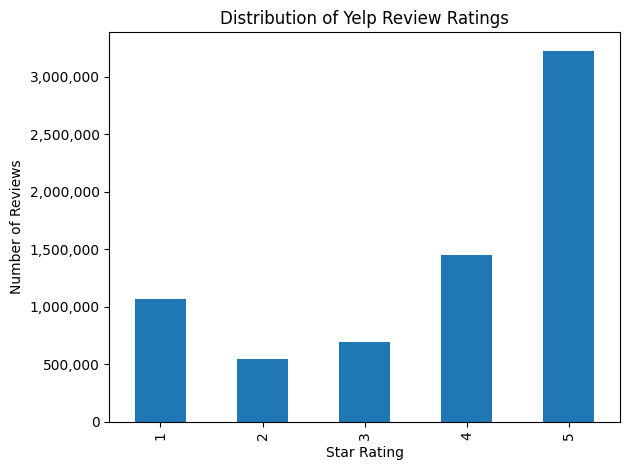

In [30]:
#15 - Show star rating distribution as a graph

star_series = (
    pd.Series(star_counts)
    .sort_index()
)

star_series.plot(kind="bar")
plt.title("Distribution of Yelp Review Ratings")
plt.xlabel("Star Rating")
plt.ylabel("Number of Reviews")

# Format y-axis with commas
plt.gca().yaxis.set_major_formatter(
    mtick.FuncFormatter(lambda x, _: f"{int(x):,}")
)

plt.tight_layout()
plt.show()


### Insight 1: Yelp Reviews Are Positively Skewed

The distribution of Yelp star ratings shows a strong skew toward higher ratings,
with the majority of reviews being 4 or 5 stars. This suggests that Yelp users
are more likely to leave reviews after positive experiences, which may introduce
a positivity bias in sentiment-based analyses. You can also see that there is more 1 star reviews than 2 & 3. This shows that people are likely more motivated to leave a review if they have an exceptionally good experience (4/5 stars) or an exceptionally poor experience (1 star)

In [31]:
#16 - Count review lengths

cap = 300
bins = 50
bin_edges = np.linspace(0, cap, bins + 1)   # 51 edges define 50 bins
hist_counts = np.zeros(bins, dtype=np.int64)

total_reviews = 0

for _, df_part in iter_parquet_chunks(
    TEXT_CLEAN_CHUNK_DIR,
    columns=["text_clean"]
):
    # word counts for this chunk
    lengths = df_part["text_clean"].str.count(r"\S+").astype(np.int32)

    # cap long reviews
    lengths = lengths.clip(upper=cap).to_numpy()

    # update histogram counts
    counts, _ = np.histogram(lengths, bins=bin_edges)
    hist_counts += counts
    total_reviews += len(lengths)

print("Total reviews processed:", total_reviews)


Total reviews processed: 6973295


In [32]:
#17 - Summarize review lengths

cum = np.cumsum(hist_counts)
n = cum[-1]

def approx_percentile(p):
    target = p * n
    idx = np.searchsorted(cum, target)
    return bin_edges[min(idx, len(bin_edges) - 1)]

summary = {
    "Total reviews processed": f"{n:,}",
    "Median review length (50th percentile)": approx_percentile(0.50),
    "90th percentile review length": approx_percentile(0.90),
    "95th percentile review length": approx_percentile(0.95),
    "99th percentile review length": approx_percentile(0.99),
    f"Reviews at max cap ({cap} words)": int(hist_counts[-1]),
}

for k, v in summary.items():
    print(f"{k}: {v}")

Total reviews processed: 6,973,295
Median review length (50th percentile): 36.0
90th percentile review length: 108.0
95th percentile review length: 144.0
99th percentile review length: 240.0
Reviews at max cap (300 words): 33930


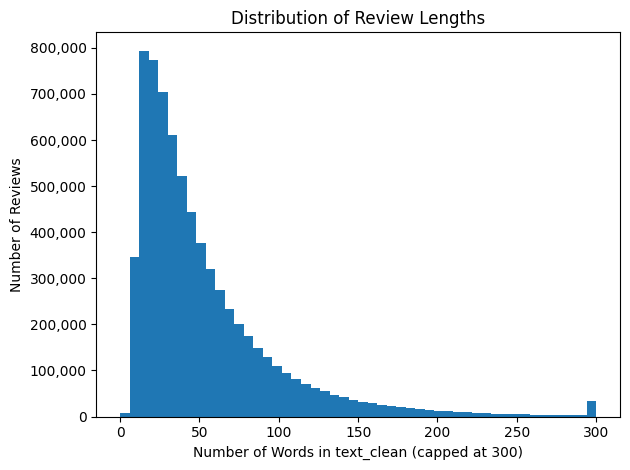

In [33]:
#18 - Visualize review length with a histogram

bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
bar_width = bin_edges[1] - bin_edges[0]

plt.bar(bin_centers, hist_counts, width=bar_width, align="center")

plt.title("Distribution of Review Lengths")
plt.xlabel(f"Number of Words in text_clean (capped at {cap})")
plt.ylabel("Number of Reviews")

plt.gca().yaxis.set_major_formatter(
    mtick.FuncFormatter(lambda x, _: f"{int(x):,}")
)

plt.tight_layout()
plt.show()

### Insight 2: Review Lengths Are Right-Skewed

The distribution of review lengths shows a strong right skew, with most Yelp
reviews containing fewer than 100 words. A smaller number of reviews are much
longer, forming a long tail. This indicates that while most users leave brief
feedback, a subset of users provide detailed reviews that may contain richer
context and sentiment for text analysis.


In [34]:
#19 - Analyze relationship between review length and star rating

# Compute the word count per review and group review lengths by star rating for downstream summary statistics
lengths_by_star = defaultdict(list)

MAX_WORDS = 300

for _, df_part in iter_parquet_chunks(
    TEXT_CLEAN_CHUNK_DIR,
    columns=["stars", "text_clean"]
):
    review_lengths = (
        df_part["text_clean"]
        .str.split()
        .str.len()
        .clip(upper=MAX_WORDS)
    )

    for star, length in zip(df_part["stars"], review_lengths):
        lengths_by_star[star].append(length)

In [37]:
#20 - Calculate median values

star_levels = sorted(lengths_by_star.keys())
median_lengths = [
    np.median(lengths_by_star[star]) for star in star_levels
]

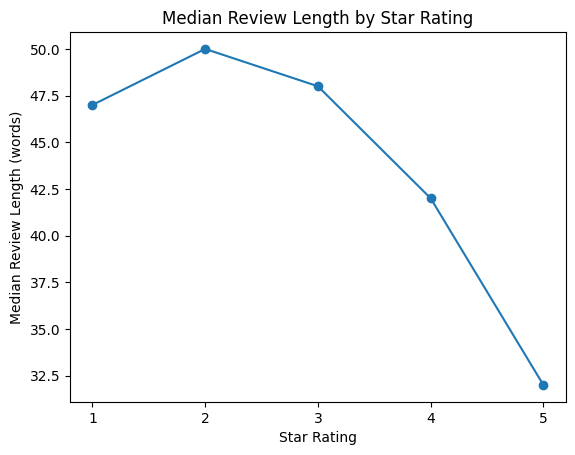

In [38]:
#21 Visualize Median Review Length by Star Rating

plt.figure()
plt.plot(star_levels, median_lengths, marker="o")
plt.xlabel("Star Rating")
plt.ylabel("Median Review Length (words)")
plt.title("Median Review Length by Star Rating")
plt.xticks(star_levels)
plt.show()

### Insight:

Low rated reviews have a tendancy to be longer than higher star ratings, suggesting that dissatisfied customers are more likely to provided detailed written feedback.

In [39]:
#22 - Star Rating Distribution and Class Balance
# For predicting dissatisfaction, we should reframe star ratings as a binary
# 1-2 Stars is Low satisfaction
# 3-5 Stars is Not low satisfaction

low_satisfaction = star_counts.get(1, 0) + star_counts.get(2, 0)
not_low_satisfaction = (
    star_counts.get(3, 0)
    + star_counts.get(4, 0)
    + star_counts.get(5, 0)
)

total_reviews = low_satisfaction + not_low_satisfaction

print(f"Low satisfaction (1–2 stars): {low_satisfaction:,} "
      f"({100 * low_satisfaction / total_reviews:.1f}%)")

print(f"Not low satisfaction (3–5 stars): {not_low_satisfaction:,} "
      f"({100 * not_low_satisfaction / total_reviews:.1f}%)")

Low satisfaction (1–2 stars): 1,609,308 (23.1%)
Not low satisfaction (3–5 stars): 5,363,987 (76.9%)


### Insight

After dividing star ratings into two classes, low satisfaction (1–2 stars) and not low satisfaction (3–5 stars), it is clear that low satisfaction reviews represent the minority class. While a future model could achieve high accuracy by predicting “not low satisfaction” for most reviews, accurately identifying dissatisfied customers will require focusing on language patterns that are specifically associated with negative reviews.

# **Creating TF Matrix by creating corpus, converting data, etc.**

In [16]:
#23 - Build sample corpus for TF / TF-IDF

# ML algorithms require numerical input, not raw text.
# The TF matrix converts each review into a vector of word counts, enabling:
#   * Classification models (sentiment prediction)
#   * Clustering algorithms (topic discovery)
#   * Similarity computations (finding related reviews)

MAX_DOCS  = 200_000   # cap to control RAM
MAX_WORDS = 300       # truncate long reviews based on prior EDA

corpus = []          # list of cleaned review texts (documents)
star_ratings = []    # corresponding star ratings

for _, df_part in iter_parquet_chunks(
    TEXT_CLEAN_CHUNK_DIR,
    columns=["stars", "text_clean"]
):
    texts = (
        df_part["text_clean"]
        .str.split()
        .str[:MAX_WORDS]
        .str.join(" ")
    )

    corpus.extend(texts.tolist())
    star_ratings.extend(df_part["stars"].tolist())

    if len(corpus) >= MAX_DOCS:
        corpus = corpus[:MAX_DOCS]
        star_ratings = star_ratings[:MAX_DOCS]
        break

print(f"Sample corpus size: {len(corpus):,} reviews")


Sample corpus size: 200,000 reviews


In [17]:
#24 - Build Term Frequency (TF) matrix
# Tokenization: Splits text into individual words (tokens)
# Vocabulary building: Creates a dictionary of all unique words
# Counting: For each document, counts occurrences of each vocabulary word
# Initialize CountVectorizer to create the TF matrix

tf_vectorizer = CountVectorizer(
    stop_words="english",
    max_features=50_000  # limit vocabulary size for stability
)

# The output is stored as a sparse matrix because:
#   * Most entries are zero (a review uses only ~50 of 24,232 vocabulary words)
#   * Sparse format stores only non-zero values, saving ~99% memory
#   * Scikit-learn algorithms are optimized for sparse input
# Fit and transform the corpus to get the TF matrix
tf_matrix = tf_vectorizer.fit_transform(corpus)

print("TF matrix shape:", tf_matrix.shape)

TF matrix shape: (200000, 50000)


In [18]:
#25 - Build TF - IDF Matrix
# LIMITATION OF RAW TF: Simple word counts treat all words equally, but some
#   words are more informative than others. "Delicious" appearing in a food
#   review is more meaningful than "food" which appears in most reviews.
# Creating TF-IDF Matrix first importing tools, creating corpus, converting data, etc.
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TfidfVectorizer to create the TF-IDF matrix
tfidf_vectorizer = TfidfVectorizer(
    stop_words="english",
    vocabulary=tf_vectorizer.vocabulary_
)

# Fit and transform the corpus to get the TF-IDF matrix
tfidf_matrix = tfidf_vectorizer.fit_transform(corpus)

print("TF-IDF matrix shape:", tfidf_matrix.shape)

TF-IDF matrix shape: (200000, 50000)


# **Vocabulary Inspection**

In [22]:
#26 - Attempting to get a view of the TF Matrix results
# VOCABULARY INSPECTION: Viewing feature names reveals:
#   * Tokenization behavior (how words are split and normalized)
#   * Presence of unexpected tokens (numbers, artifacts)
#   * Vocabulary size and composition

# Get feature names (words) from the CountVectorizer
tf_feature_names = tf_vectorizer.get_feature_names_out()

print("First 20 TF feature names:")
print(tf_feature_names[:20])
print(f"\nTotal TF features: {len(tf_feature_names)}")

# Display a portion of the TF matrix for the first review
print("\nTF matrix for the first review (non-zero entries):")
row = tfidf_matrix[0]
nonzero_indices = row.nonzero()[1]

# Get indices of non-zero counts
nonzero_indices = first_review_tf.nonzero()[1]

# Map indices back to feature names and their counts
for idx in nonzero_indices:
    print(f"  {tf_feature_names[idx]}: {first_review_tf[0, idx]}")

First 20 TF feature names:
['aa' 'aah' 'aahed' 'aahh' 'aahhmazing' 'aahs' 'aamaazing' 'aamazing'
 'aamco' 'aand' 'aanrader' 'aaron' 'aarp' 'aart' 'ab' 'aback' 'abalone'
 'abandon' 'abandoned' 'abandoning']

Total TF features: 50000

TF matrix for the first review (non-zero entries):
  aware: 1
  bad: 1
  beginning: 1
  come: 1
  decide: 1
  diner: 1
  eat: 1
  end: 1
  experience: 2
  food: 1
  going: 1
  good: 1
  hour: 1
  like: 1
  location: 1
  long: 2
  multiple: 1
  nj: 1
  opt: 1
  order: 1
  pleasant: 1
  quicker: 1
  restaurant: 1
  spent: 1
  time: 2
  tried: 1
  usually: 2
  waiting: 1
  waitstaff: 1
  want: 1
  way: 1
  weekend: 1
  young: 1


In [21]:
#27 - Attempting to get a view of the TF-IDF Matrix results

# Get feature names (words) from the TfidfVectorizer
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

print("First 20 TF-IDF feature names:")
print(tfidf_feature_names[:20])
print(f"\nTotal TF-IDF features: {len(tfidf_feature_names)}")

# Display a portion of the TF-IDF matrix for the first review
print("\nTF-IDF matrix for the first review (non-zero entries):")

row = tfidf_matrix[0]                 # sparse row
nonzero_indices = row.nonzero()[1]    # column indices with non-zero weights

# Get indices of non-zero values
nonzero_indices_tfidf = first_review_tfidf.nonzero()[1]

# Map indices back to feature names and their TF-IDF scores
for idx in nonzero_indices_tfidf:
    print(f"  {tfidf_feature_names[idx]}: {first_review_tfidf[0, idx]:.4f}")

First 20 TF-IDF feature names:
['aa' 'aah' 'aahed' 'aahh' 'aahhmazing' 'aahs' 'aamaazing' 'aamazing'
 'aamco' 'aand' 'aanrader' 'aaron' 'aarp' 'aart' 'ab' 'aback' 'abalone'
 'abandon' 'abandoned' 'abandoning']

Total TF-IDF features: 50000

TF-IDF matrix for the first review (non-zero entries):
  aware: 0.2226
  bad: 0.1254
  beginning: 0.2207
  come: 0.1040
  decide: 0.2042
  diner: 0.1842
  eat: 0.1182
  end: 0.1493
  experience: 0.2170
  food: 0.0661
  going: 0.1144
  good: 0.0686
  hour: 0.1218
  like: 0.0828
  location: 0.1241
  long: 0.2519
  multiple: 0.1879
  nj: 0.2460
  opt: 0.2603
  order: 0.1048
  pleasant: 0.1665
  quicker: 0.2622
  restaurant: 0.1002
  spent: 0.1806
  time: 0.1547
  tried: 0.1261
  usually: 0.2904
  waiting: 0.1493
  waitstaff: 0.2191
  want: 0.1170
  way: 0.1134
  weekend: 0.1547
  young: 0.1867


The difference between a TF Matrix and TF-IDF Matrix:


*   A TF Matrix counts how many times each word appears in each document
*   A TF-IDF Matrix weights each word by how distinctive it is across the entire corpus



